# Importación de bibliotecas

In [ ]:
!pip install datasets evaluate

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import numpy as np
import wandb
import json
import os

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
!pip freeze | grep -E "datasets|evaluate|transformers|scikit-learn|matplotlib|pandas|numpy|wandb|seaborn|matplotlib"

datasets==3.6.0
evaluate==0.4.3
geopandas==1.0.1
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.2
numpy==2.0.2
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.28.0
pandas-stubs==2.2.2.240909
scikit-learn==1.6.1
seaborn==0.13.2
sentence-transformers==3.4.1
sklearn-pandas==2.2.0
tensorflow-datasets==4.9.8
transformers==4.51.3
vega-datasets==0.9.0
wandb==0.19.10


LogIn en WandB

In [ ]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pabloorlw (pabloorlw-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Obtención del dataset y preprocesado

In [ ]:
# --- Configuración inicial ---
DATASET_NAME = "dair-ai/emotion"
MODEL_NAME = "distilbert/distilbert-base-uncased"
NUM_LABELS = 5

In [ ]:
dataset = load_dataset(DATASET_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Visualización de la distribución de clases

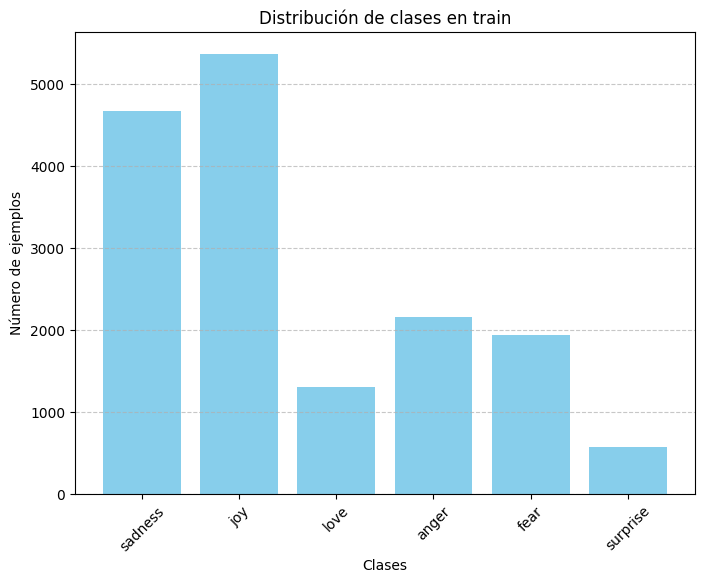

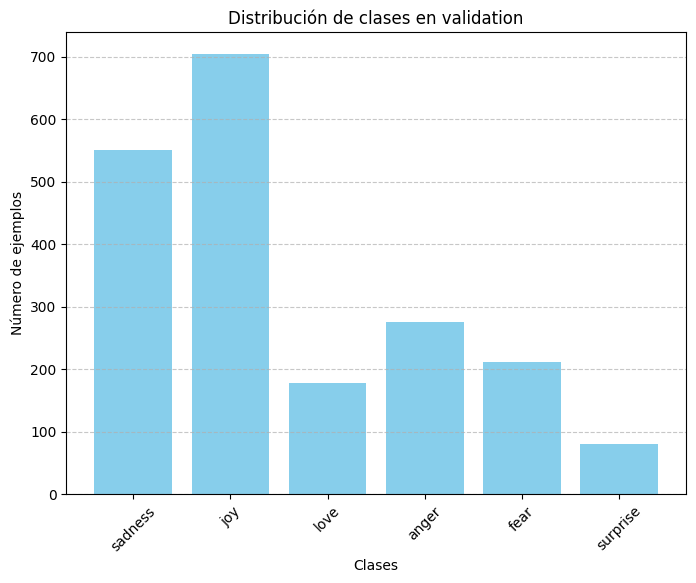

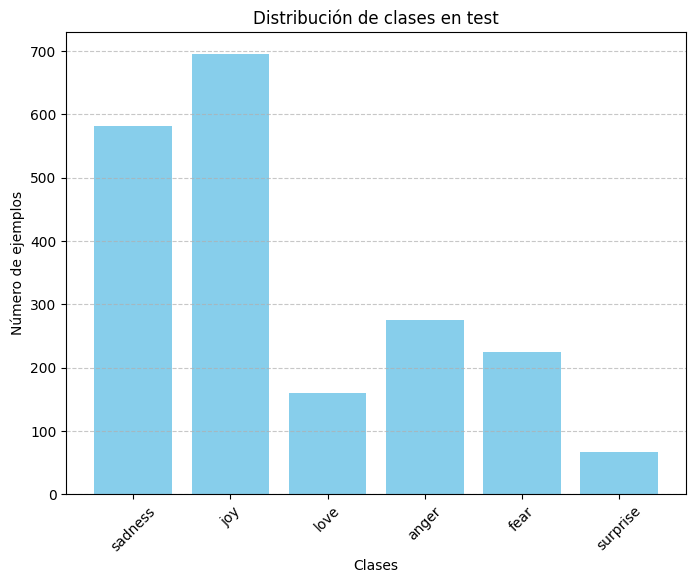

In [ ]:
def plot_class_distribution(dataset, split_name):
    dataset_split = dataset[split_name]
    label_list = dataset_split["label"]
    labels_unique, counts = np.unique(label_list, return_counts=True)

    id_to_label = dataset[split_name].features["label"].names
    label_names = [id_to_label[i] for i in labels_unique]

    plt.figure(figsize=(8, 6))
    plt.bar(label_names, counts, color="skyblue")
    plt.title(f"Distribución de clases en {split_name}")
    plt.xlabel("Clases")
    plt.ylabel("Número de ejemplos")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_class_distribution(dataset, "train")
plot_class_distribution(dataset, "validation")
plot_class_distribution(dataset, "test")

Filtrado para quedarnos solo con las 5 clases comunes a los 3 datasets

In [ ]:
# Obtener el ID de la clase "love"
label_feature = dataset["train"].features["label"]
love_id = label_feature.str2int("love")

# Filtrar el dataset
filtered_dataset = dataset.filter(lambda example: example["label"] != love_id)

# Obtener las etiquetas originales sin "love"
original_labels = label_feature.names
new_labels = [label for label in original_labels if label != "love"]

# Crear un mapeo de IDs antiguos a nuevos
old_to_new_labels = {label_feature.str2int(label): i for i, label in enumerate(new_labels)}

# Reindexar las etiquetas en cada split
def update_labels(example):
    example["label"] = old_to_new_labels[example["label"]]
    return example

reindexed_dataset = filtered_dataset.map(update_labels)

# Creamos un nuevo esquema de etiqueta
new_label_feature = ClassLabel(names=new_labels)

# Actualizamos las características del dataset
reindexed_dataset = DatasetDict({
    split: ds.cast_column("label", new_label_feature)
    for split, ds in reindexed_dataset.items()
})

print(reindexed_dataset["train"].features["label"])

Filter:   0%|          | 0/16000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14696 [00:00<?, ? examples/s]

Map:   0%|          | 0/1822 [00:00<?, ? examples/s]

Map:   0%|          | 0/1841 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14696 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1822 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1841 [00:00<?, ? examples/s]

ClassLabel(names=['sadness', 'joy', 'anger', 'fear', 'surprise'], id=None)


Visualización del dataset filtrado

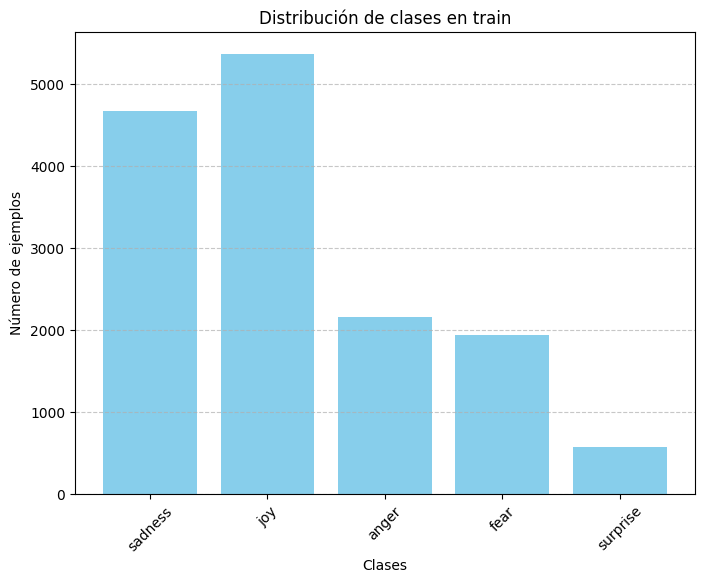

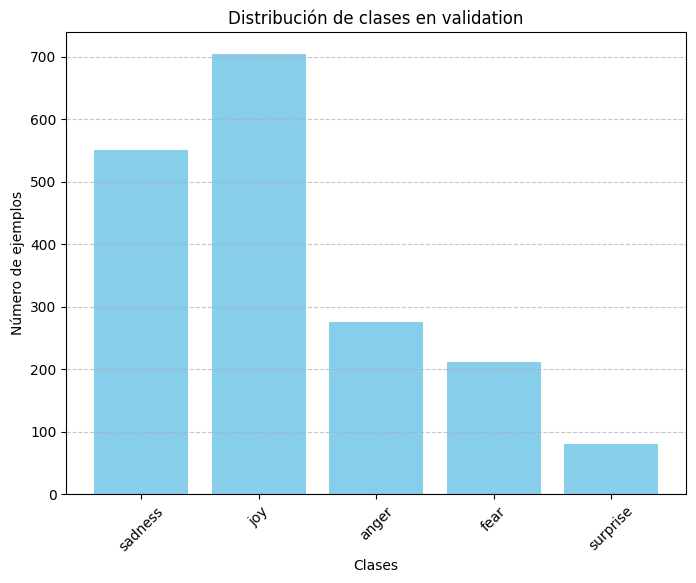

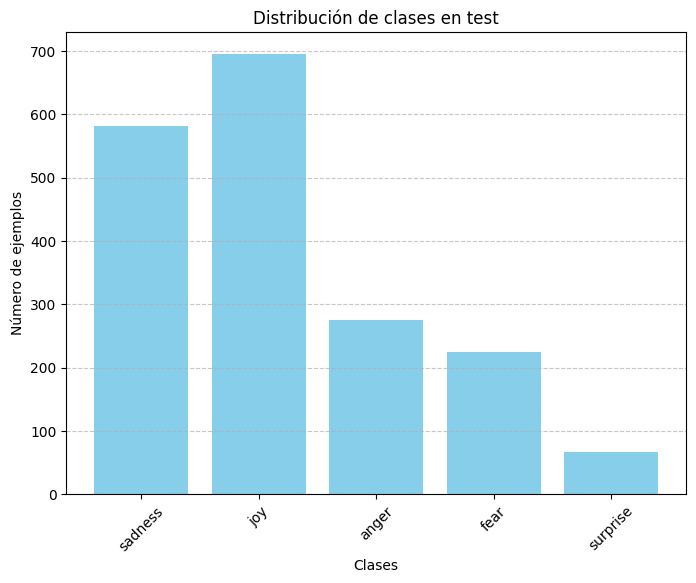

In [ ]:
plot_class_distribution(reindexed_dataset, "train")
plot_class_distribution(reindexed_dataset, "validation")
plot_class_distribution(reindexed_dataset, "test")

Tokenización

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

tokenized_datasets = reindexed_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/14696 [00:00<?, ? examples/s]

Map:   0%|          | 0/1822 [00:00<?, ? examples/s]

Map:   0%|          | 0/1841 [00:00<?, ? examples/s]

# Entrenamiento

Obtención del modelo

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

In [ ]:
# --- Hiperparámetros ---
num_epochs = 10
lr = 2e-5
batch_size = 64
weight_decay=0.01
seed = 42

In [ ]:
# --- Inicio en WandB ---
wandb.init(project="emotion-distilbert", name="emotion-distilbert-5clases_5", config={
    "model": MODEL_NAME,
    "dataset": "EMOTION (5 clases)",
    "epochs": num_epochs,
    "lr": lr,
    "batch_size": batch_size,
    "seed": seed
})

wandb: Currently logged in as: pabloorlw (pabloorlw-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# --- Argumentos de entrenamiento ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    seed=seed,
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=1,
    save_strategy="epoch",
    metric_for_best_model="f1"
)

In [ ]:
# --- Entrenador ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# --- Entrenamiento ---
trainer.train()

<ipython-input-16-67394c6f6d2f>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631700,0.190070,0.936334,0.935897


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631700,0.190070,0.936334,0.935897
2,0.143800,0.151323,0.946762,0.946717
3,0.096800,0.138569,0.950055,0.950021
4,0.071000,0.136792,0.954995,0.954618
5,0.058300,0.150027,0.948957,0.949696
6,0.043200,0.143688,0.952799,0.952868
7,0.037400,0.137904,0.953897,0.953588
8,0.028500,0.145884,0.954995,0.955007
9,0.025200,0.141857,0.959385,0.959408
10,0.021300,0.141328,0.959385,0.959418


TrainOutput(global_step=2300, training_loss=0.11570762302564538, metrics={'train_runtime': 7107.6589, 'train_samples_per_second': 20.676, 'train_steps_per_second': 0.324, 'total_flos': 1.94684504272896e+16, 'train_loss': 0.11570762302564538, 'epoch': 10.0})

# Evaluación en test

In [ ]:
# Liberar memoria
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print("Test Accuracy:", test_results["eval_accuracy"])
print("Test F1 Score:", test_results["eval_f1"])

# Logs personalizados en WandB
wandb.log({"Test Accuracy": test_results["eval_accuracy"],"Test F1": test_results["eval_f1"]})

Test Accuracy: 0.9451385116784357
Test F1 Score: 0.9449995390613782


              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.98      0.98      0.98       695
       anger       0.92      0.91      0.92       275
        fear       0.86      0.91      0.88       224
    surprise       0.80      0.71      0.75        66

    accuracy                           0.95      1841
   macro avg       0.90      0.89      0.90      1841
weighted avg       0.95      0.95      0.94      1841



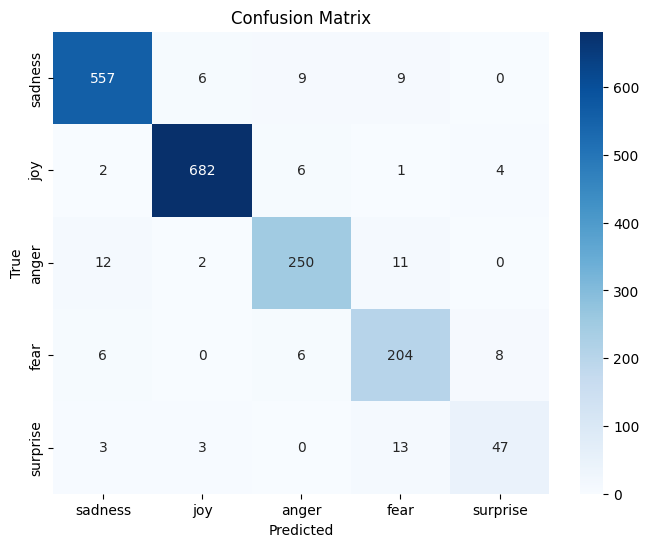

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)

true_labels = tokenized_datasets["test"]["label"]

target_names = reindexed_dataset["train"].features["label"].names

# Reporte
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Matriz de confusió
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Guardado del modelo y etiquetas

In [ ]:
output_dir = "./emotion-distilbert"
os.makedirs(output_dir, exist_ok=True)

# --- Modelo y tokenizer ---
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# --- Mapeo de etiquetas ---
id_to_label = reindexed_dataset["train"].features["label"].names
label_to_id = {v: k for k, v in enumerate(id_to_label)}

label_mapping = {
    "id2label": {str(k): v for k, v in enumerate(id_to_label)},
    "label2id": label_to_id
}

label_mapping_path = os.path.join(output_dir, "label_encoder.json")
with open(label_mapping_path, "w") as f:
    json.dump(label_mapping, f, indent=4)